# Compact Mixed Integer Linear Programming Model for Balancing Bike Sharing Systems 

In [100]:
import gurobipy as gb
import networkx as nx
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import pandas as pd
import numpy as np

In [101]:
def draw_initial_graph(G):
    global scale
    global DrawG
    DrawG = pygv.AGraph(strict='true', splines='true', directed=True)
    scale = 15
    
    for i in G.nodes():
        pos = str(G.node[i]['x'] * scale) + ',' + str((G.node[i]['y']) * scale)

        if G.node[i]['load'] < 0:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], color='red',
                           style='filled', fillcolor='salmon', fontsize='8', width='0.3')
        elif G.node[i]['load'] > 0:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], color='green',
                           style='filled', fillcolor='palegreen1', fontsize='8', width='0.3')
        else:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], fontsize='8', width='0.3')
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw(path=basename + '.svg', format='svg')
    DrawG.clear()
    
    
def draw_solution(G, x, y, veichles):
    pos = str(G.node['0']['x'] * scale) + ',' + str((G.node['0']['y']) * scale)
    DrawG.add_node('0', shape='circle', pos=pos, label=G.node['0']['label'], fontsize='8', width='0.3')
    pos = str(G.node['1']['x'] * scale) + ',' + str((G.node['1']['y']) * scale)
    DrawG.add_node('1', shape='circle', pos=pos, label=G.node['1']['label'], fontsize='8', width='0.3')
     
    for i in G.nodes()-{'0', '1'}:
        for v in veichles:
            if x[i, v].x == 1:
                lab = G.node[i]['label']+"_"+str(v)
                t = i.split(" ")
                pos = str(G.node[i]['x'] * float(t[1][0]) * scale) + ',' + str(G.node[i]['y'] * scale)
                if G.node[i]['load'] < 0:
                    DrawG.add_node(i, shape='circle', pos=pos, label=lab, color='red', style='filled', 
                                   fillcolor='salmon', fontsize='8', width='0.1')
                elif G.node[i]['load'] > 0:
                    DrawG.add_node(i, shape='circle', pos=pos, label=lab, color='green', style='filled', 
                                   fillcolor='palegreen1', fontsize='8', width='0.1')
    
    # associate a color to each veichle
    colors = ['red', 'blue', 'green', 'orange3', 'lightslategrey', 'darkslateblue']
    dict_veichles = []
    for i in range(0, len(veichles)):
        dict_veichles.append({'veichle': veichles[i], 'color': colors[i]})
    
    for i, j in G.edges():
        for v in dict_veichles:
            if y[i, j, v['veichle']].x == 1:
                lab = "(%s, %s) %s"%(i,j,v['veichle'])
                DrawG.add_edge(i, j, color=v['color'], label= v['veichle'], fontsize='8', splines='spline')
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw(path=basename +"_sol" + '.svg', format='svg')
    DrawG.clear()

## Problem Definition

**Given:**

- A set of stations $S$ and a set of homogeneous vehicles $L$.

- A common time budget $\;t̂\;$ (drivers’ shift times) within which they have to finish their routes.

- For each station $s \in S$ the number of full vehicle loads $f_s$ to be delivered $(f_s \le −1)$ or picked up $(f_s \ge 1)$ such that the station achieves its (approximately) ideal target fill level.


**Find:**

The maximum number of full vehicle loads picked up and delivered to the stations, such that the total balance increase in the system.  

A station, to which bikes shall be delivered is called a *delivery station*, while a station from which bikes should be removed is called a *pickup station*. At pickup stations, only pickups may be performed, while at delivery stations, only deliveries, and we never allow more than $|f_s |$ visits at each station.

>**Note**
>
>Stations
that are already at their desired target fill level (or require
less than a full vehicle load) are ignored from any further
consideration.

### Graph

For modeling tours with up to $|f_s |$ visits at each station $s \in S$, a directed bipartite graph $G = (V ,A)$ as been defined as follows. Let

$$V_\text{pic} = \{(s,i)\;|\;s \in S \land f_s \ge 1,\;i=1,...,|f_s|\}$$

be a set of nodes representing up to $|f_s|$ visits at each pickup station, and let

$$V_\text{del} = \{(s,i)\;|\;s \in S \land f_s \le -1,\;i=1,...,f_s\}$$

denote the respective potential visits at the delivery stations. $V=V_\text{pic} \cup V_\text{del}$ then refers to the joined set of all potential visits, and the arc set of graph $G$ is given by

$$ A=\{(u,v),\;(v,u)\;|\;u \in V_\text{pic},\; v \in V_\text{del}\} $$

Further the set of stations $V$ as been extended by two nodes $0$ and $1$ representing the depot at the beginning and the end of each tour, respectively, obtaining $V_0 = V \cup \{0, 1\}$. 

Node $0$ is connected to all pickup nodes, while $1$ is connected to all delivery nodes, that is, $A_0= A \cup \{(0,v) \;|\; v \in V_\text{pic}\} \cup \{(v,1) \;|\; v \in V_\text{del}\}$, yielding a bipartite graph $G_0 = (V_0, A_0)$. 

Each arc $(u, v) \in A_0$ represents an actual trip from the location represented by visit $u$ to the location represented by visit $v$ and has a corresponding traveling time $t_{uv} > 0$ associated.

### Model 

#### Decision variables

$$
x_{vl}=\begin{cases}1 \text { if station visits $v \in V$ is assigned to vehicle $l \in L$}\\
0 \text{ otherwise}
\end{cases}
$$

$$
y\ ^l_{uv}=\begin{cases}1 \text { if arc $(u, v) \in A$ is assigned to vehicle $l \in L$}\\
0 \text{ otherwise}
\end{cases}
$$

$$
a_v=\{ \text{ position in the tour in which the node $v$ is visited }\}
$$

#### Formulation

$$
\begin{alignat}{4}
&\max \sum_{l \in L} \sum_{v \in V} x_{lv} &\\\\
\text{s.t.} \;\;\;\;\;&\\
\\
\sum_{l \in L} x_{vl} &\le 1 \;\;\; \forall v \in V \;\;\; \text{(1)}\\ 
\sum_{v \in V_{\text{pic}}} x_{vl} &= \sum_{v \in V_{\text{del}}} x_{vl} \;\;\; \forall l \in L \;\;\; \text{(2)}\\
\sum_{l' \in L} x_{(s,i)l'} &\ge x_{(s,i+1)l} \;\;\; \forall s \in S ,\; l \in L, \; i = 1,....,f_s-1 \;\;\; \text{(3)}\\
\sum_{v \in V_{\text{pic}}} y\ ^l_{0v} &= 1 \;\;\; \forall l \in L \;\;\; \text{(4)}\\
\sum_{v \in V_{\text{del}}} y\ ^l_{v1} &= 1 \;\;\; \forall l \in L \;\;\; \text{(5)}\\
\sum_{(u,v) \in A_0} y\ ^l_{uv} &= x_{ul} \;\;\; \forall l \in L, \; u \in V \;\;\; \text{(6)}\\
\sum_{(u,v) \in A_0} y\ ^l_{uv} &= x_{vl} \;\;\; \forall l \in L, \; v \in V \;\;\; \text{(7)}\\
\sum_{(u,v) \in A_0} y\ ^l_{uv} &= \sum_{(v,u) \in A_0} y\ ^l_{vu} \;\;\; \forall l \in L, \; v \in V \;\;\; \text{(8)}\\
\sum_{(u,v) \in A_0} t_{uv} \cdot y\ ^l_{uv} &\le \;t̂ \;\;\; \forall l \in L \;\;\; \text{(9)}\\
a_u - a_v + |V| \cdot y\ ^l_{uv} &\le |V| - 1 \;\;\; \forall l \in L,\; (u,v) \in A \;\;\; \text{(10)}\\
\\
x_{vl} &\in \{0,1\} \;\;\; \forall l \in L,\; v \in V\\
y\ ^l_{ul} &\in \{0,1\} \;\;\; \forall l \in L,  \; (u,v) \in A_0\\
1 &\le a_v \le |V| \;\;\; \forall v \in V 
\end{alignat}
$$


## First implementation of the model

### Graph description

The graph used for the first implementation of the model is a directed graph made by 20 nodes, representing visits to 11 different stations, and 178 edges. The <span style='color: red'>red</span> nodes represents **depot** stations, while the <span style='color: green'>green</span> ones are the **pickup** stations. The starting depot is represented by the node $0$, while the ending depot is represented by the node $1$.

For each node the first number is the identifier of the station $s$ and the second number is the value of $|f_s|$. 

The maximum distance value between two nodes is **4870**.

In [102]:
filename = 'graph.gml'

basename = os.path.splitext(filename)[0]

G = nx.read_graphml (filename, node_type=str)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

G has 20 nodes and 178 edges
True


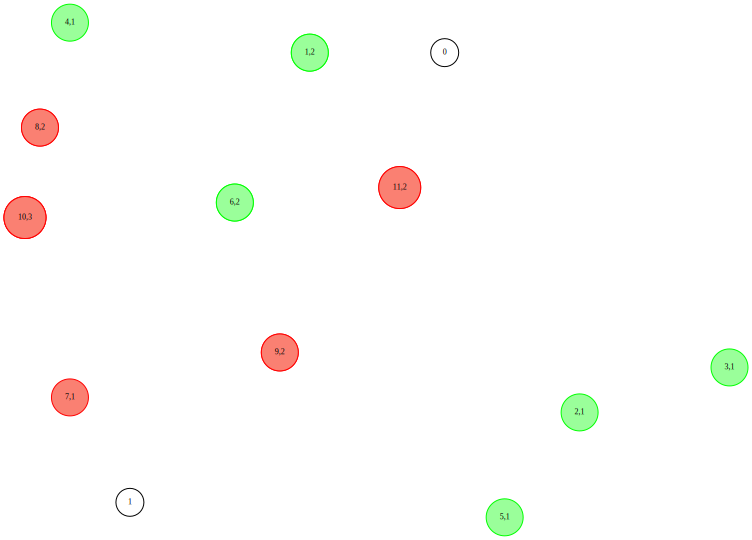

In [103]:
draw_initial_graph(G)
display(SVG(filename=basename+'.svg'))

In [104]:
G.nodes(data=True)

NodeDataView({'(7, 1)': {'station': 7, 'load': -1, 'label': '7,1', 'x': 13, 'y': 17}, '(8, 1)': {'station': 8, 'load': -2, 'label': '8,1', 'x': 11, 'y': 35}, '(8, 2)': {'station': 8, 'load': -2, 'label': '8,2', 'x': 11, 'y': 35}, '(9, 1)': {'station': 9, 'load': -2, 'label': '9,1', 'x': 27, 'y': 20}, '(9, 2)': {'station': 9, 'load': -2, 'label': '9,2', 'x': 27, 'y': 20}, '(10, 1)': {'station': 10, 'load': -3, 'label': '10,1', 'x': 10, 'y': 29}, '(10, 2)': {'station': 10, 'load': -3, 'label': '10,2', 'x': 10, 'y': 29}, '(10, 3)': {'station': 10, 'load': -3, 'label': '10,3', 'x': 10, 'y': 29}, '(11, 1)': {'station': 11, 'load': -2, 'label': '11,1', 'x': 35, 'y': 31}, '(11, 2)': {'station': 11, 'load': -2, 'label': '11,2', 'x': 35, 'y': 31}, '(1, 1)': {'station': 1, 'load': 2, 'label': '1,1', 'x': 29, 'y': 40}, '(1, 2)': {'station': 1, 'load': 2, 'label': '1,2', 'x': 29, 'y': 40}, '(2, 1)': {'station': 2, 'load': 1, 'label': '2,1', 'x': 47, 'y': 16}, '(3, 1)': {'station': 3, 'load': 1, 'l

In [105]:
edges = nx.to_pandas_edgelist(G)

In [106]:
edges

,source,target,time
0,"(7, 1)","(1, 1)",2801
1,"(7, 1)","(1, 2)",2801
2,"(7, 1)","(2, 1)",3401
3,"(7, 1)","(3, 1)",4404
4,"(7, 1)","(4, 1)",2500
5,"(7, 1)","(5, 1)",3008
6,"(7, 1)","(6, 1)",1702
7,"(7, 1)","(6, 2)",1702
8,"(7, 1)",1,806
9,"(8, 1)","(1, 1)",1868


In [107]:
print("Maximum distance time between nodes:",edges['time'].max())

Maximum distance time between nodes: 4870


### Model implementation

In [149]:
L = [i for i in range(1,5)] #4 vehicles
t_budget = 300000         #time budget
start_depot = '0'
end_depot = '1'
stations = [1,2,3,4,5,6,7,8,9,10,11]

In [150]:
v_pick = [i for i in G.nodes() if G.node[i]['load'] > 0] # pickup nodes
v_del = [i for i in G.nodes() if G.node[i]['load'] < 0] # delivery nodes
station_visits = G.nodes()-{start_depot, end_depot} # V set

In [151]:
mod = gb.Model()

In [152]:
x = mod.addVars(station_visits, L, obj=1, vtype=gb.GRB.BINARY, name='x')

y = mod.addVars(G.edges(), L, vtype=gb.GRB.BINARY, name='y')

a = mod.addVars(G.nodes(), lb=1.0, ub=len(station_visits), vtype=gb.GRB.CONTINUOUS, name='a')

mod.ModelSense = gb.GRB.MAXIMIZE
mod.write('model.lp')

>#### Constr 1
>
>Every station visit is performed by at most one vehicle

In [153]:
mod.addConstrs((x.sum(v, '*') <= 1 for v in station_visits), name='CSTR1')
mod.update()
mod.write('model.lp')

>#### Constr 2
>Every tour contains the same amount of pickup visits as delivery visits

In [154]:
for l in L:
    mod.addConstr(gb.quicksum([x[v,l] for v in v_pick]) == gb.quicksum([x[v,l] for v in v_del]), name='CSTR2_%s'%l)
    mod.update()
mod.write('model.lp')

>#### Constr 3
>The $i + 1$ th visit can only be performed when the $i$ th visit is performed, for $i = 1, . . . , f_s − 1$ and each station $s \in S$.

In [155]:
for s in stations:
    for l in L:
        for i in range(1, abs(G.node[str((s, 1))]['load'])):
            mod.addConstr(x.sum(str((s, i)), '*') >= x[str((s, i+1)), l], name='CSTR3_(%s,%s)_%s' % (s,i,l))
            mod.update()
mod.write('model.lp')

>#### Constr 4
>For each vehicle the depot’s starting node $0$ has to have one outgoing arc

In [156]:
for l in L:
    mod.addConstr(y.sum(start_depot, v_pick, l) == 1, name='CSTR4_%s'%l)
    mod.update()
mod.write('model.lp')

>#### Constr 5
>The depot’s target node $1$ has to have one incoming arc

In [157]:
for l in L:
    mod.addConstr(y.sum(v_del,end_depot, l) == 1, name='CSTR5_%s'%l)
    mod.update()
mod.write('model.lp')

>#### Constr 6
>Every node $u \in V$ has one outgoing arc iff it is assigned to vehicle $l$.

In [158]:
for l in L:
    for u in station_visits:
        mod.addConstr(y.sum(u, '*', l) == x[u, l], name='CSTR6_(%s)_%s'%(u,l))
        mod.update()
mod.write('model.lp')

>#### Constr 7
>Each node $v \in V$ which is assigned to vehicle $l \in L$ has to have one corresponding ingoing arc.

In [159]:
for l in L:
    for v in station_visits:
        mod.addConstr(y.sum('*', v, l) == x[v, l], name='CSTR7_(%s)_%s'%(v,l))
        mod.update()
mod.write('model.lp')

>#### Constr 8
>The number of ingoing arcs has to be equal to the number of outgoing arcs foreach node $v \in V,\; l \in L$

In [160]:
for l in L:
    for v in station_visits:
        mod.addConstr(
            y.sum('*', v, l) == y.sum(v, '*', l),
            name = 'CSTR8_%s_%s'%(l,v))
        mod.update()
mod.write('model.lp')

>#### Constr 9
>The routes for each vehicle has to lie within the allowed time budget.

In [161]:
t = nx.get_edge_attributes(G,'time')

In [162]:
mod.addConstrs((gb.quicksum([t[u, v] * y[u, v, l] for u, v in G.edges()]) <= t_budget for l in L), name = 'CSTR9')
mod.update()
mod.write('model.lp')

>#### Constr 10
>MTZ subtour inequalities

In [163]:
a[start_depot].lb = 1
a[start_depot].ub = 1

for l in L:
    for u, v in G.edges():
        if u != start_depot and u != end_depot and v != start_depot and v != end_depot: 
            mod.addConstr(
            a[u] - a[v] + len(station_visits) * y[u, v, l] <= len(station_visits) - 1, 
                name='CSTR10_(%s,%s)%s'%(u,v,l))
            mod.update()
mod.write('model.lp')

In [164]:
mod.optimize()

Optimize a model with 918 rows, 804 columns and 5836 nonzeros
Variable types: 20 continuous, 784 integer (784 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 3e+05]
Found heuristic solution: objective 8.0000000
Presolve removed 4 rows and 2 columns
Presolve time: 0.01s
Presolved: 914 rows, 802 columns, 5124 nonzeros
Variable types: 18 continuous, 784 integer (784 binary)

Root relaxation: objective 1.600000e+01, 211 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      16.0000000   72.00000   350%     -    0s
     0     0          -    0        16.00000   16.00000  0.00%     -    0s

Explored 0 nodes (709 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 16 8 

Optimal 

In [165]:
print("Linear relaxation:",1.600000e+01)
print("Number of visits made:",mod.ObjVal)

Linear relaxation: 16.0
Number of visits made: 16.0


In [166]:
draw_solution(G, x, y, L)

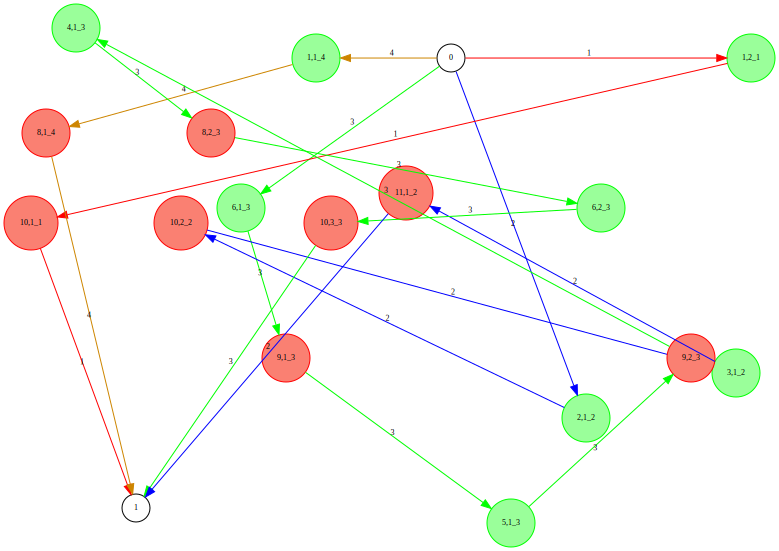

In [167]:
display(SVG(filename=basename+'_sol'+'.svg'))

### Performance analysis

The graph above shows the routes of each vehicle and, differently from the initial graph, here we distinguish the visit on each station to better describe the different routes. 
The model, with this small instance, is able to find the optimal solution immediately exploring zero nodes, since it is equal to the linear relaxation. 
Next we will test the model on a bigger instance.

## Test on a bigger instance

In [168]:
def model(G, name):
    mod = gb.Model()
    
    x = mod.addVars(station_visits, L, obj=1, vtype=gb.GRB.BINARY, name='x')
    y = mod.addVars(G.edges(), L, vtype=gb.GRB.BINARY, name='y')
    a = mod.addVars(G.nodes(), lb=1.0, ub=len(station_visits), vtype=gb.GRB.CONTINUOUS, name='a')
    mod.ModelSense = gb.GRB.MAXIMIZE
    mod.addConstrs((x.sum(v, '*') <= 1 for v in station_visits), name='CSTR1')
    mod.update()
    
    for l in L:
        mod.addConstr(gb.quicksum([x[v,l] for v in v_pick]) == gb.quicksum([x[v,l] for v in v_del]), name='CSTR2_%s'%l)
        mod.update()
        
    for s in stations:
        for l in L:
            for i in range(1, abs(G.node[str((s, 1))]['load'])):
                mod.addConstr(x.sum(str((s, i)), '*') >= x[str((s, i+1)), l], name='CSTR3_(%s,%s)_%s' % (s,i,l))
                mod.update()
    
    for l in L:
        mod.addConstr(y.sum(start_depot, v_pick, l) == 1, name='CSTR4_%s'%l)
        mod.update()
        
    for l in L:
        mod.addConstr(y.sum(v_del,end_depot, l) == 1, name='CSTR5_%s'%l)
        mod.update()
        
    for l in L:
        for u in station_visits:
            mod.addConstr(y.sum(u, '*', l) == x[u, l], name='CSTR6_(%s)_%s'%(u,l))
            mod.update()
    
    for l in L:
        for v in station_visits:
            mod.addConstr(y.sum('*', v, l) == x[v, l], name='CSTR7_(%s)_%s'%(v,l))
            mod.update()
    
    for l in L:
        for v in station_visits:
            mod.addConstr(
                y.sum('*', v, l) == y.sum(v, '*', l),
                name = 'CSTR8_%s_%s'%(l,v))
            mod.update()
            
    t = nx.get_edge_attributes(G,'time')
    mod.addConstrs((gb.quicksum([t[u, v] * y[u, v, l] for u, v in G.edges()]) <= t_budget for l in L), name = 'CSTR9')
    mod.update()
    
    a[start_depot].lb = 1
    a[start_depot].ub = 1

    for l in L:
        for u, v in G.edges():
            if u != start_depot and u != end_depot and v != start_depot and v != end_depot: 
                mod.addConstr(
                    a[u] - a[v] + len(station_visits) * y[u, v, l] <= len(station_visits) - 1, 
                    name='CSTR10_(%s,%s)%s'%(u,v,l))
                mod.update()
    
    mod.write(name)
    return mod

Here we test the model on a bigger instance. The graph used here is made by **467** nodes and **108397** edges. 

As before the <span style='color: green'>green</span> nodes are the pickup stations and the <span style='color: red'>red</span> ones are the delivery stations. The range of visits for each station goes from //TODO

In [169]:
filename = 'graph2.gml'

basename = os.path.splitext(filename)[0]

G = nx.read_graphml (filename, node_type=str)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

G has 467 nodes and 108397 edges
True


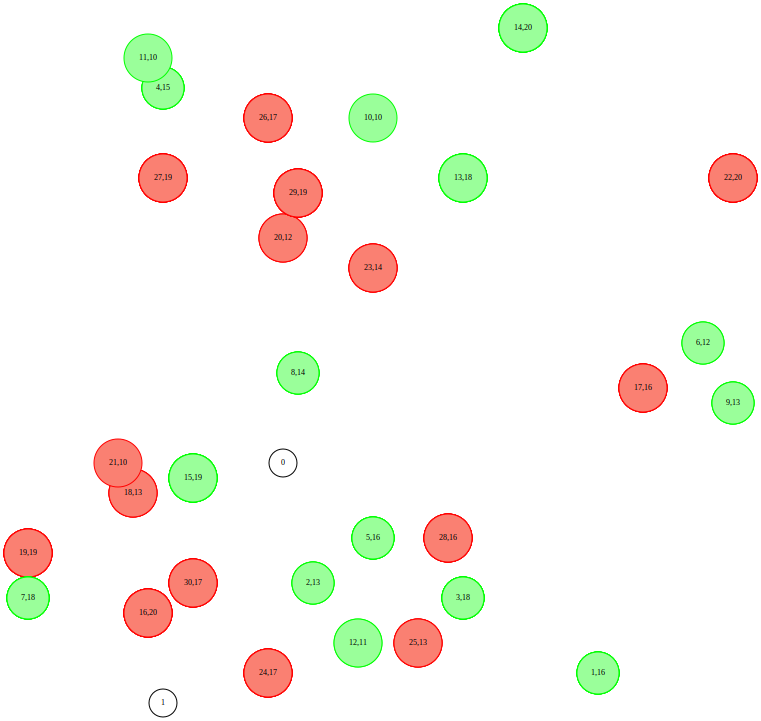

In [170]:
draw_initial_graph(G)
display(SVG(filename=basename+'.svg'))

In [179]:
G.nodes(data=True)
pd.DataFrame(G.nodes(data=True), index= G.nodes(), columns=['station', )

AssertionError: 7 columns passed, passed data had 2 columns

In [172]:
edges = nx.to_pandas_edgelist(G)

In [173]:
edges

,source,target,time
0,"(16, 1)","(1, 1)",3026
1,"(16, 1)","(1, 2)",3026
2,"(16, 1)","(1, 3)",3026
3,"(16, 1)","(1, 4)",3026
4,"(16, 1)","(1, 5)",3026
5,"(16, 1)","(1, 6)",3026
6,"(16, 1)","(1, 7)",3026
7,"(16, 1)","(1, 8)",3026
8,"(16, 1)","(1, 9)",3026
9,"(16, 1)","(1, 10)",3026


In [174]:
print("Maximum distance time between nodes:",edges['time'].max())

Maximum distance time between nodes: 5470


In [180]:
model = model(G, 'model2.lp')

KeyError: ('(1, 3)', 1)